# DataTables, Indexes, Pandas, and Seaborn

## Some useful (free) resources

Introductory:

* [Getting started with Python for research](https://github.com/TiesdeKok/LearnPythonforResearch), a gentle introduction to Python in data-intensive research.

* [A Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/index.html), by Jake VanderPlas, another quick Python intro (with notebooks).

Core Pandas/Data Science books:

* [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/), by Jake VanderPlas.

* [Python for Data Analysis, 2nd Edition](http://proquest.safaribooksonline.com/book/programming/python/9781491957653), by  Wes McKinney, creator of Pandas. [Companion Notebooks](https://github.com/wesm/pydata-book)

* [Effective Pandas](https://github.com/TomAugspurger/effective-pandas), a book by Tom Augspurger, core Pandas developer.


Complementary resources:

* [An introduction to "Data Science"](https://github.com/stefanv/ds_intro), a collection of Notebooks by BIDS' [Stéfan Van der Walt](https://bids.berkeley.edu/people/st%C3%A9fan-van-der-walt).

* [Effective Computation in Physics](http://proquest.safaribooksonline.com/book/physics/9781491901564), by Kathryn D. Huff; Anthony Scopatz. [Notebooks to accompany the book](https://github.com/physics-codes/seminar). Don't be fooled by the title, it's a great book on modern computational practices with very little that's physics-specific.


OK, let's load and configure some of our core libraries (as an aside, you can find a nice visual gallery of available matplotlib sytles [here](https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html)).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_context("notebook")

## Getting the Data

https://www.ssa.gov/OACT/babynames/index.html

https://www.ssa.gov/data

We can download data from the internet with Python, and do so only if needed:

In [2]:
import requests
from pathlib import Path

namesbystate_path = Path('namesbystate.zip')
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'

if not namesbystate_path.exists():
    print('Downloading...', end=' ')
    resp = requests.get(data_url)
    with namesbystate_path.open('wb') as f:
        f.write(resp.content)
    print('Done!')

## What were the most popular California male & female names in each year?

### Extracting from a ZIP archive

We can see how large the compressed and uncompressed data are:

In [3]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')
sum(f.file_size for f in zf.filelist) / 1_000_000

122.38892

In [4]:
sum(f.compress_size for f in zf.filelist) / 1_000_000

21.568281

In [5]:
__/_  # divide the next-previous result by the previous one

5.674486529547719

What are these data?

In [6]:
zf.extract('StateReadMe.pdf')

'/Users/denero/Documents/workspace/100/sp19-site/assets/lectures/lec03/StateReadMe.pdf'

We want the names for California.

In [7]:
print([f.filename for f in zf.filelist])

['AK.TXT', 'AL.TXT', 'AR.TXT', 'AZ.TXT', 'CA.TXT', 'CO.TXT', 'CT.TXT', 'DC.TXT', 'DE.TXT', 'FL.TXT', 'GA.TXT', 'HI.TXT', 'IA.TXT', 'ID.TXT', 'IL.TXT', 'IN.TXT', 'KS.TXT', 'KY.TXT', 'LA.TXT', 'MA.TXT', 'MD.TXT', 'ME.TXT', 'MI.TXT', 'MN.TXT', 'MO.TXT', 'MS.TXT', 'MT.TXT', 'NC.TXT', 'ND.TXT', 'NE.TXT', 'NH.TXT', 'NJ.TXT', 'NM.TXT', 'NV.TXT', 'NY.TXT', 'OH.TXT', 'OK.TXT', 'OR.TXT', 'PA.TXT', 'RI.TXT', 'SC.TXT', 'SD.TXT', 'StateReadMe.pdf', 'TN.TXT', 'TX.TXT', 'UT.TXT', 'VA.TXT', 'VT.TXT', 'WA.TXT', 'WI.TXT', 'WV.TXT', 'WY.TXT']


In [8]:
ca_name = 'CA.TXT'
with zf.open(ca_name) as f:
    for i in range(10):
        print(f.readline().rstrip().decode())

CA,F,1910,Mary,295
CA,F,1910,Helen,239
CA,F,1910,Dorothy,220
CA,F,1910,Margaret,163
CA,F,1910,Frances,134
CA,F,1910,Ruth,128
CA,F,1910,Evelyn,126
CA,F,1910,Alice,118
CA,F,1910,Virginia,101
CA,F,1910,Elizabeth,93


In [9]:
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    ca = pd.read_csv(fh, header=None, names=field_names)
ca.head()

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


In [10]:
ca.shape

(374634, 5)

### Group by year

In [11]:
ca[(ca['Year'] == 1995) & (ca['Sex'] == 'M')].head()

,State,Sex,Year,Name,Count
311664,CA,M,1995,Daniel,5003
311665,CA,M,1995,Michael,4783
311666,CA,M,1995,Jose,4572
311667,CA,M,1995,Christopher,4098
311668,CA,M,1995,David,4029


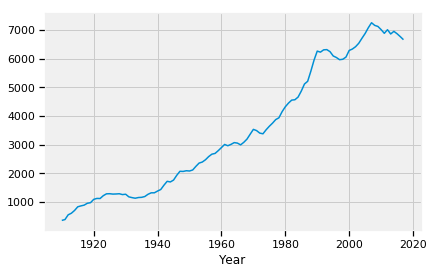

In [12]:
ca.groupby('Year').size().plot();

### Grouping by multiple columns

In [13]:
ca.groupby(['Year', 'Sex']).size().head()

Year  Sex
1910  F      233
      M      130
1911  F      251
      M      142
1912  F      303
dtype: int64

In [14]:
ca.groupby(['Year', 'Sex']).size().head()

Year  Sex
1910  F      233
      M      130
1911  F      251
      M      142
1912  F      303
dtype: int64

In [15]:
most_popular_names = (ca.groupby(['Year', 'Sex']).first())
most_popular_names.head()

State  Name  Count
Year Sex                   
1910 F      CA  Mary    295
     M      CA  John    237
1911 F      CA  Mary    390
     M      CA  John    214
1912 F      CA  Mary    534

As we'd expect, we get a MultiIndexed DataFrame, which we can index using [] just like our single indexed DataFrames.

In [16]:
most_popular_names[most_popular_names['Name'] == 'John']

,,State,Name,Count
Year,Sex,,,
1910,M,CA,John,237
1911,M,CA,John,214
1912,M,CA,John,501
1913,M,CA,John,614
1914,M,CA,John,769
1915,M,CA,John,1033
1916,M,CA,John,1086
1917,M,CA,John,1066


`.loc` is a bit more complicated:

In [17]:
most_popular_names.loc[2017, :, :]

State  Name  Count
Year Sex                   
2017 F      CA  Emma   2726
     M      CA  Noah   2511

In [18]:
pop_pivot = ca.pivot_table(
    index='Sex',
    columns='Year',
    values='Name',
    aggfunc=lambda ns: ns.iloc[0]
)
pop_pivot

Year,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Sex,,,,,,,,,,,,,,,,,,,,,
F,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,Mary,...,Isabella,Isabella,Isabella,Sophia,Sophia,Sophia,Sophia,Sophia,Mia,Emma
M,John,John,John,John,John,John,John,John,Robert,Robert,...,Daniel,Daniel,Jacob,Jacob,Jacob,Jacob,Noah,Noah,Noah,Noah


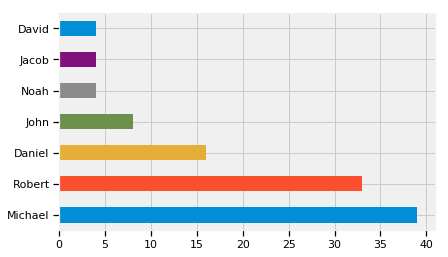

In [19]:
pop_pivot.loc['M'].value_counts().plot(kind='barh');

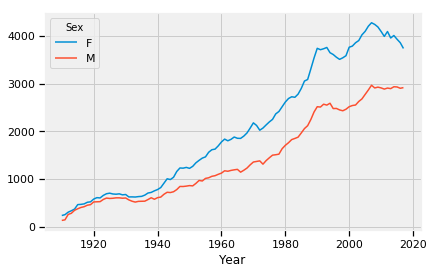

In [20]:
ca.pivot_table(
    index='Year',
    columns='Sex',
    values='Name',
    aggfunc=len,
).plot();

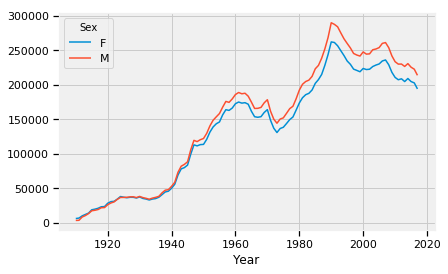

In [21]:
ca.pivot_table(
    index='Year',
    columns='Sex',
    values='Count',
    aggfunc=sum,
).plot();

## Can I deduce birth sex from the last letter of a person’s name?

### Compute last letter of each name

In [22]:
ca.head()

,State,Sex,Year,Name,Count
0,CA,F,1910,Mary,295
1,CA,F,1910,Helen,239
2,CA,F,1910,Dorothy,220
3,CA,F,1910,Margaret,163
4,CA,F,1910,Frances,134


In [23]:
ca['Name'].str[-1].head()

0    y
1    n
2    y
3    t
4    s
Name: Name, dtype: object

To add column to dataframe:

In [24]:
ca['Last'] = ca['Name'].str[-1]
ca.head()

,State,Sex,Year,Name,Count,Last
0,CA,F,1910,Mary,295,y
1,CA,F,1910,Helen,239,n
2,CA,F,1910,Dorothy,220,y
3,CA,F,1910,Margaret,163,t
4,CA,F,1910,Frances,134,s


### Group by last letter and sex

In [25]:
letter_counts = (ca
                 .loc[:, ('Sex', 'Count', 'Last')]
                 .groupby(['Last', 'Sex'])
                 .sum())
letter_counts.head()

Count
Last Sex         
a    F    5750384
     M     185959
b    F        894
     M     147627
c    F       2889

### Visualize our result

Use .plot to get some basic plotting functionality:

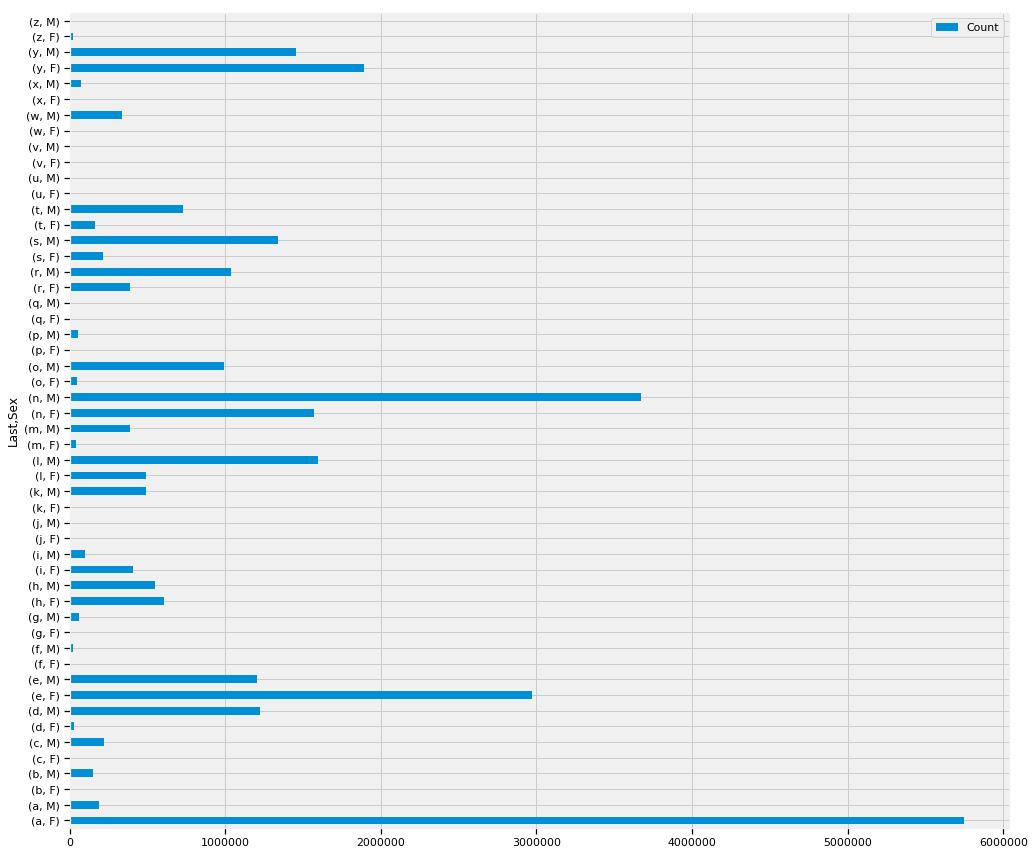

In [26]:
# Why is this not good?
letter_counts.plot.barh(figsize=(15, 15));

Reading the docs shows me that pandas will make one set of bars for each column in my table. How do I move each sex into its own column? I have to use pivot:

In [27]:
# For comparison, the group above:
# letter_counts = (baby_names
#                  .loc[:, ('Sex', 'Count', 'Last letter')]
#                  .groupby(['Last letter', 'Sex'])
#                  .sum())

last_letter_pivot = ca.pivot_table(
    index='Last', # the rows (turned into index)
    columns='Sex', # the column values
    values='Count', # the field(s) to processed in each group
    aggfunc=sum, # group operation
)
last_letter_pivot.head()

Sex,F,M
Last,,
a,5750384,185959
b,894,147627
c,2889,219350
d,28728,1222725
e,2974686,1206604


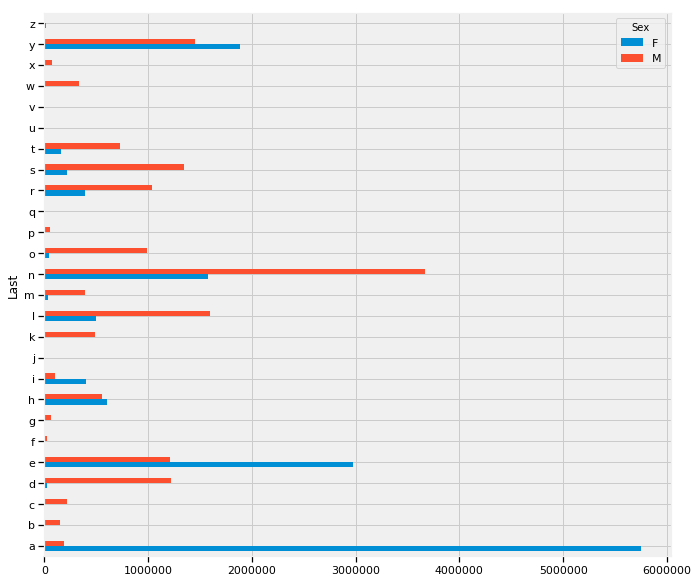

In [28]:
last_letter_pivot.plot.barh(figsize=(10, 10));

Why is this still not ideal?

- Plotting raw counts
- Not sorted by any order

In [29]:
totals = last_letter_pivot['F'] + last_letter_pivot['M']

last_letter_props = pd.DataFrame({
    'F': last_letter_pivot['F'] / totals,
    'M': last_letter_pivot['M'] / totals,
}).sort_values('M')
last_letter_props.head()

,F,M
Last,,
a,0.968674,0.031326
i,0.804707,0.195293
e,0.711428,0.288572
z,0.689834,0.310166
y,0.564982,0.435018


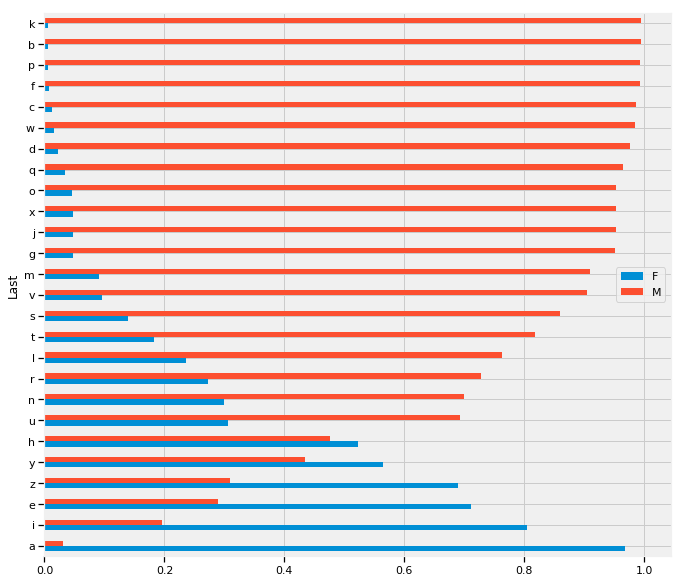

In [30]:
last_letter_props.plot.barh(figsize=(10, 10));